## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from scipy.stats import norm
import plotly.figure_factory as ff
from plotly.offline import iplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
import scikitplot as skplt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
sns.set(style = 'whitegrid')

## Loading dataset

In [2]:
df = pd.read_csv('./Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## Generating sweetviz report

In [5]:
report = sv.analyze(df, 'Attrition')

In [6]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## EDA

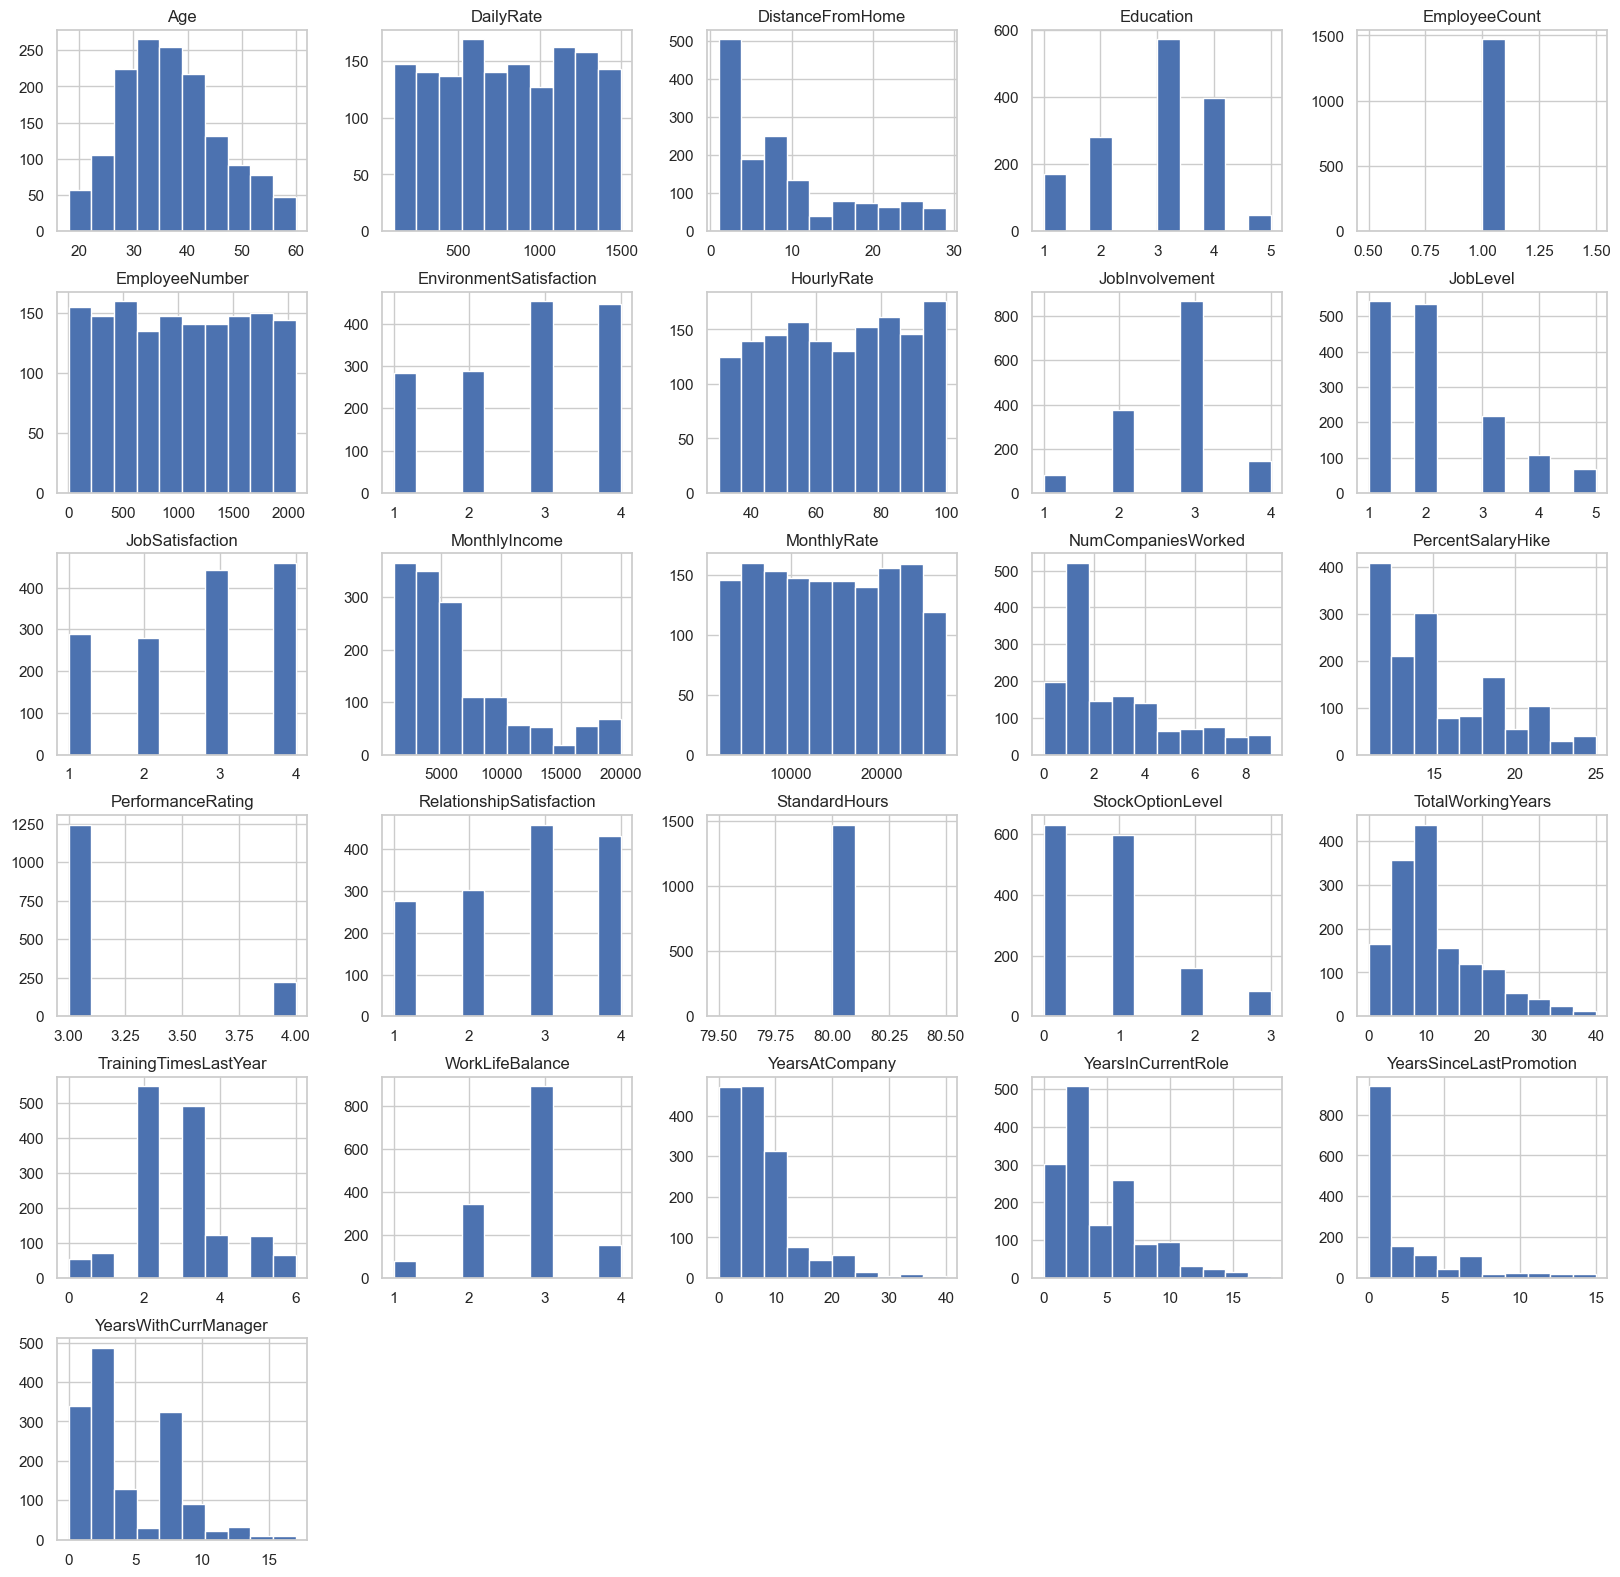

In [7]:
sns.set(style = 'whitegrid')
df.hist(figsize = (20, 20))
plt.show()

## Feature distribution by target variable

### Age

In [8]:
(mu_yes, sigma_yes) = norm.fit(df.loc[df.Attrition == 'Yes', 'Age'])

In [9]:
print(mu_yes, sigma_yes)

33.607594936708864 9.668886620354689


In [10]:
(mu_no, sigma_no) = norm.fit(df.loc[df.Attrition == 'No', 'Age'])

In [11]:
print(mu_no, sigma_no)

37.561232765612324 8.884754930516747


In [12]:
x1 = df.loc[df.Attrition == 'No', 'Age']
x2 = df.loc[df.Attrition == 'Yes', 'Age']

In [13]:
hist_data = [x1, x2]
group_labels = ['active_employees', 'ex_employees']

In [14]:
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)

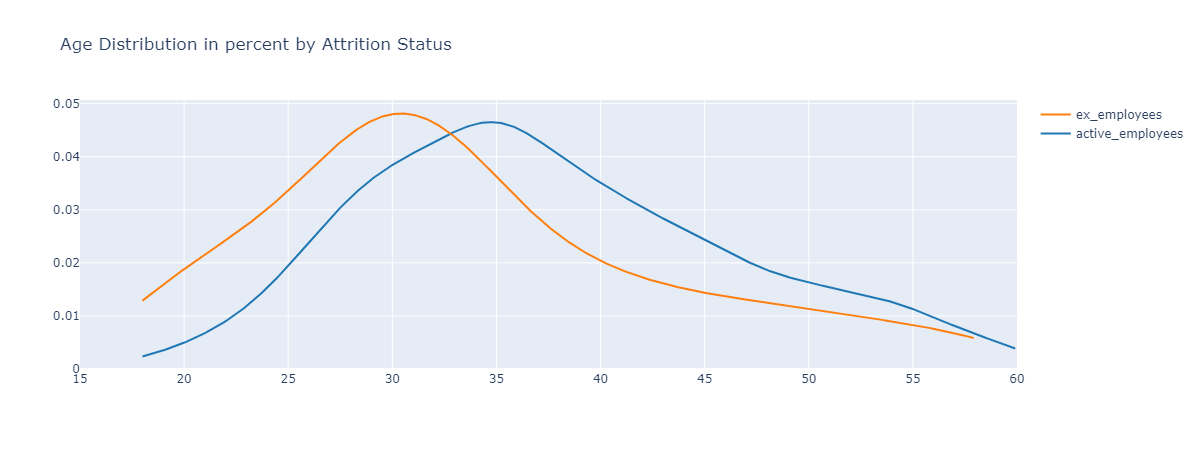

In [15]:
fig['layout'].update(title = 'Age Distribution in percent by Attrition Status')
fig['layout'].update(xaxis = dict(range = [15, 60], dtick = 5))
fig.show()

<AxesSubplot:xlabel='Age'>

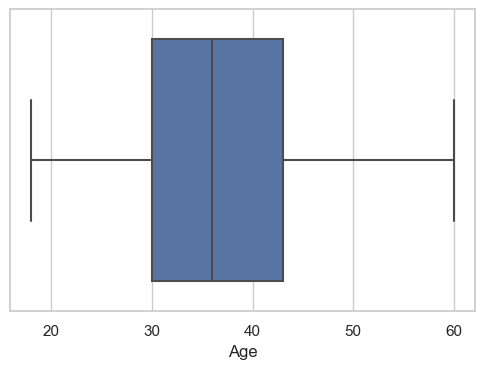

In [16]:
sns.boxplot(x = df.Age)

- No outliers

### Education Field

In [17]:
df.EducationField.value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

<AxesSubplot:title={'center':'Leavers by Education Field (%)'}, xlabel='Field'>

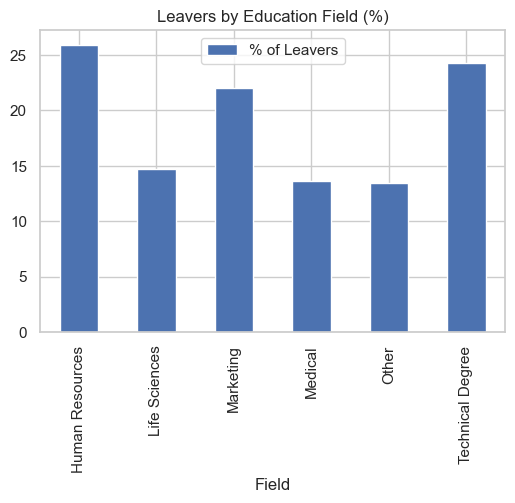

In [18]:
df_education_field = pd.DataFrame(columns = ['Field', '% of Leavers'])
for i, field in enumerate(list(df.EducationField.unique())):
    ratio = df[(df.EducationField == field) & (df.Attrition == 'Yes')].shape[0] / df[df.EducationField == field].shape[0]
    df_education_field.loc[i] = (field, ratio * 100)
df_EF = df_education_field.groupby(by = 'Field').sum()
df_EF.plot(kind = 'bar', title = 'Leavers by Education Field (%)')

### Gender

In [19]:
df.Gender.value_counts()

Male      882
Female    588
Name: Gender, dtype: int64

In [20]:
print('Gender distribution of ex-employees in the dataset: Male = {:.1f}%: Female = {:.1f}%'.format((df[(df.Gender == 'Male') & (df.Attrition == 'Yes')].shape[0] / 
      df[df.Gender == 'Male'].shape[0]) * 100, (df[(df.Gender == 'Female') & (df.Attrition == 'Yes')].shape[0] / 
      df[df.Gender == 'Female'].shape[0]) * 100))

Gender distribution of ex-employees in the dataset: Male = 17.0%: Female = 14.8%


<AxesSubplot:title={'center':'Leavers by Gender (%)'}, xlabel='gender'>

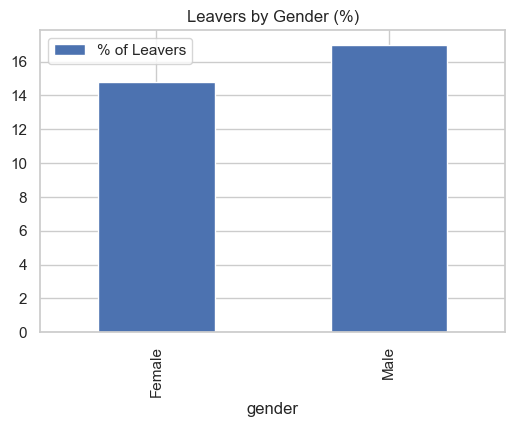

In [21]:
df_gender = pd.DataFrame(columns = ['gender', '% of Leavers'])
for i, gender in enumerate(list(df.Gender.unique())):
    ratio = df[(df.Gender == gender) & (df.Attrition == 'Yes')].shape[0] / df[df.Gender == gender].shape[0]
    df_gender.loc[i] = (gender, ratio * 100)
df_G = df_gender.groupby(by = 'gender').sum()
df_G.plot(kind = 'bar', title = 'Leavers by Gender (%)')

### Marital Status

In [22]:
df.MaritalStatus.value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

<AxesSubplot:title={'center':'Leavers by marital status (%)'}, xlabel='marital_status'>

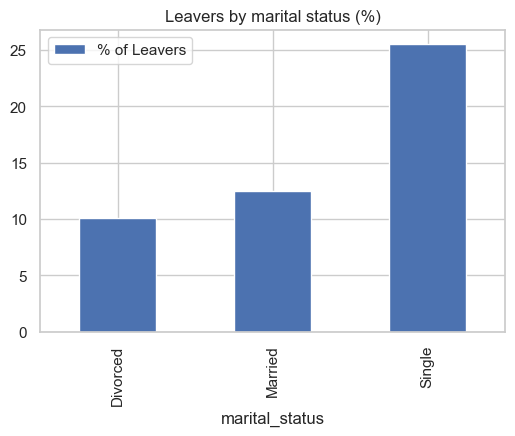

In [23]:
df_marital = pd.DataFrame(columns = ['marital_status', '% of Leavers'])
for i, marital in enumerate(list(df.MaritalStatus.unique())):
    ratio = df[(df.MaritalStatus == marital) & (df.Attrition == 'Yes')].shape[0] / df[df.MaritalStatus == marital].shape[0]
    df_marital.loc[i] = (marital, ratio * 100)
df_MS = df_marital.groupby(by = 'marital_status').sum()
df_MS.plot(kind = 'bar', title = 'Leavers by marital status (%)')

### Distance from home

In [24]:
print("Distance from home for employees to get to work is from {} to {} miles.".format(df.DistanceFromHome.min(), df.DistanceFromHome.max()))

Distance from home for employees to get to work is from 1 to 29 miles.


In [25]:
print('Average distance from home for: Current employees = {:.2f}: Ex-employees = {:.2f}'.format((df[df.Attrition == 'No'].DistanceFromHome.mean()), 
                                                                                                 (df[df.Attrition == 'Yes'].DistanceFromHome.mean())))

Average distance from home for: Current employees = 8.92: Ex-employees = 10.63


In [26]:
x1 = df.loc[df.Attrition == 'No', 'DistanceFromHome']
x2 = df.loc[df.Attrition == 'Yes', 'DistanceFromHome']
hist = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']

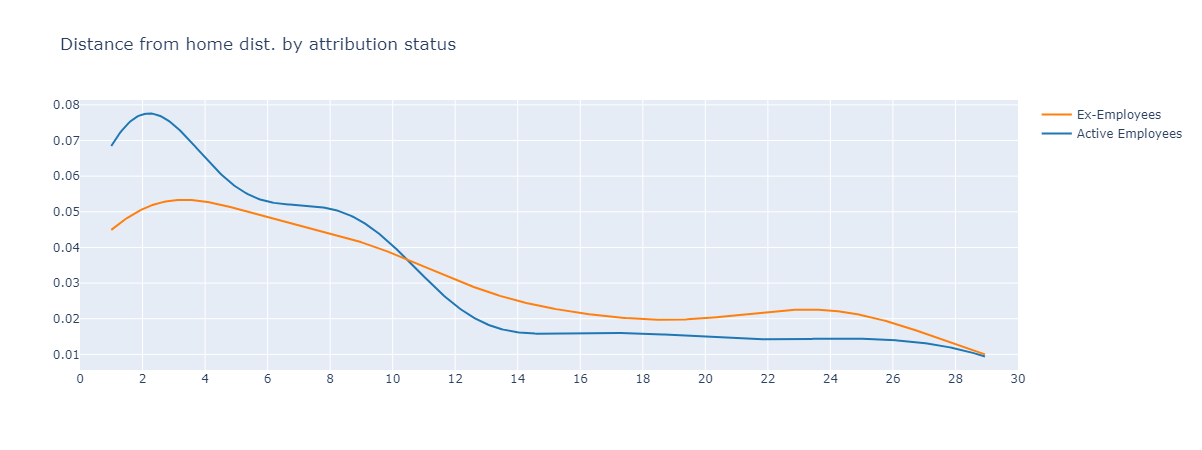

In [27]:
fig = ff.create_distplot(hist, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Distance from home dist. by attribution status')
fig['layout'].update(xaxis = dict(range = [0, 30], dtick = 2))
fig.show()

<AxesSubplot:xlabel='DistanceFromHome'>

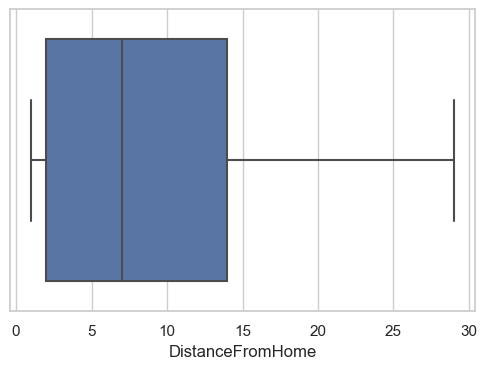

In [28]:
sns.boxplot(x = df.DistanceFromHome)

### Department

In [29]:
df.Department.value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

<AxesSubplot:title={'center':'Leavers by department (%)'}, xlabel='department'>

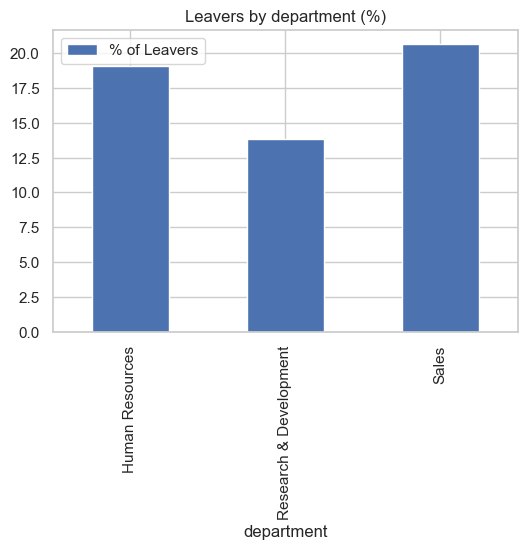

In [30]:
df_department = pd.DataFrame(columns = ['department', '% of Leavers'])
for i, department in enumerate(list(df.Department.unique())):
    ratio = df[(df.Department == department) & (df.Attrition == 'Yes')].shape[0] / df[df.Department == department].shape[0]
    df_department.loc[i] = (department, ratio * 100)
df_D = df_department.groupby(by = 'department').sum()
df_D.plot(kind = 'bar', title = 'Leavers by department (%)')

### Travel frequency

In [31]:
df.BusinessTravel.value_counts()

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

<AxesSubplot:title={'center':'Leavers by their frequency of travel (%)'}, xlabel='business_travel'>

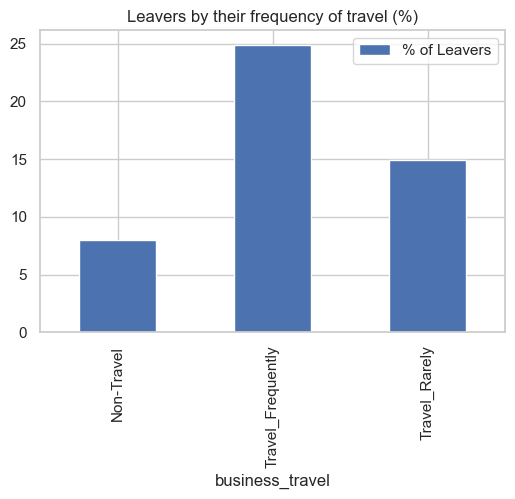

In [32]:
df_business_travel = pd.DataFrame(columns = ['business_travel', '% of Leavers'])
for i, travel in enumerate(list(df.BusinessTravel.unique())):
    ratio = df[(df.BusinessTravel == travel) & (df.Attrition == 'Yes')].shape[0] / df[df.BusinessTravel == travel].shape[0]
    df_business_travel.loc[i] = (travel, ratio * 100)
df_BT = df_business_travel.groupby(by = 'business_travel').sum()
df_BT.plot(kind = 'bar', title = 'Leavers by their frequency of travel (%)')

### Job role

In [33]:
df.JobRole.value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

<AxesSubplot:title={'center':'Leavers by job role (%)'}, xlabel='job_role'>

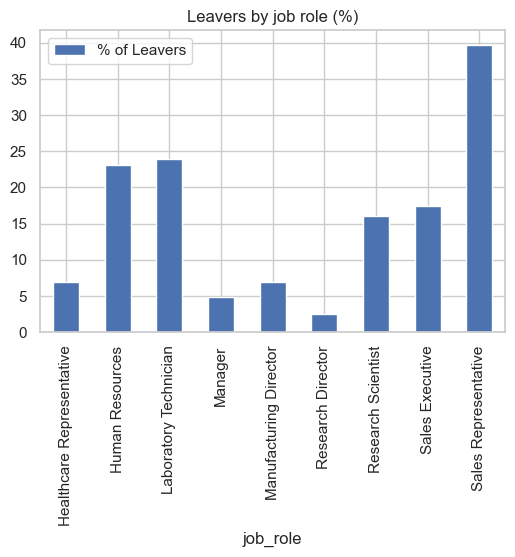

In [34]:
df_job_role = pd.DataFrame(columns = ['job_role', '% of Leavers'])
for i, job_role in enumerate(list(df.JobRole.unique())):
    ratio = df[(df.JobRole == job_role) & (df.Attrition == 'Yes')].shape[0] / df[df.JobRole == job_role].shape[0]
    df_job_role.loc[i] = (job_role, ratio * 100)
df_JR = df_job_role.groupby(by = 'job_role').sum()
df_JR.plot(kind = 'bar', title = 'Leavers by job role (%)')

### Job level

In [35]:
df.JobLevel.value_counts()

1    543
2    534
3    218
4    106
5     69
Name: JobLevel, dtype: int64

<AxesSubplot:title={'center':'Leavers by job level (%)'}, xlabel='job_level'>

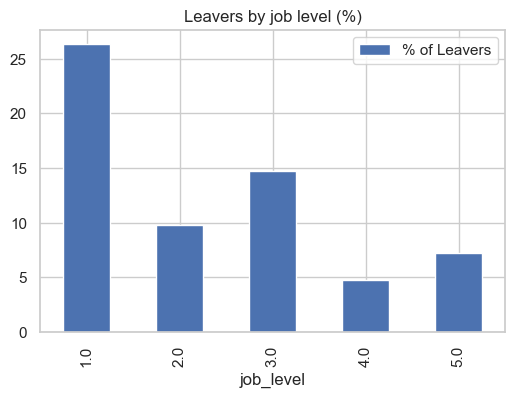

In [36]:
df_job_level = pd.DataFrame(columns = ['job_level', '% of Leavers'])
for i, job_level in enumerate(list(df.JobLevel.unique())):
    ratio = df[(df.JobLevel == job_level) & (df.Attrition == 'Yes')].shape[0] / df[df.JobLevel == job_level].shape[0]
    df_job_level.loc[i] = (job_level, ratio * 100)
df_JL = df_job_level.groupby(by = 'job_level').sum()
df_JL.plot(kind = 'bar', title = 'Leavers by job level (%)')

### Job involvement

In [37]:
df.JobInvolvement.value_counts()

3    868
2    375
4    144
1     83
Name: JobInvolvement, dtype: int64

<AxesSubplot:title={'center':'Leavers by job involvement (%)'}, xlabel='job_involvement'>

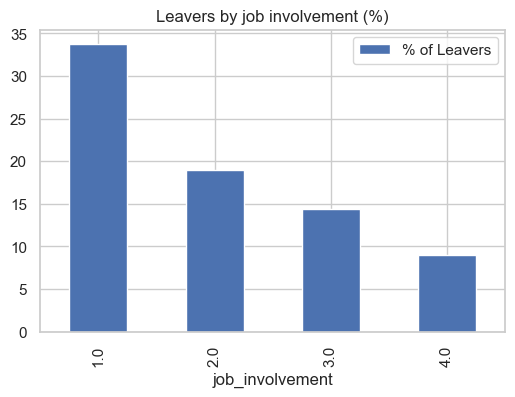

In [38]:
df_job_involvement = pd.DataFrame(columns = ['job_involvement', '% of Leavers'])
for i, job_involvement in enumerate(list(df.JobInvolvement.unique())):
    ratio = df[(df.JobInvolvement == job_involvement) & (df.Attrition == 'Yes')].shape[0] / df[df.JobInvolvement == job_involvement].shape[0]
    df_job_involvement.loc[i] = (job_involvement, ratio * 100)
df_JI = df_job_involvement.groupby(by = 'job_involvement').sum()
df_JI.plot(kind = 'bar', title = 'Leavers by job involvement (%)')

### Training time

In [39]:
df.TrainingTimesLastYear.value_counts()

2    547
3    491
4    123
5    119
1     71
6     65
0     54
Name: TrainingTimesLastYear, dtype: int64

<AxesSubplot:title={'center':'Leavers by job involvement (%)'}, xlabel='training'>

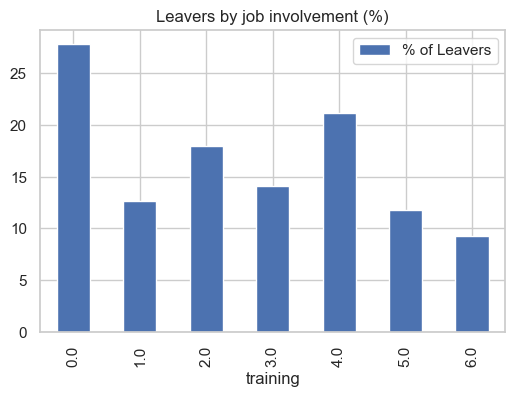

In [40]:
df_training = pd.DataFrame(columns = ['training', '% of Leavers'])
for i, training in enumerate(list(df.TrainingTimesLastYear.unique())):
    ratio = df[(df.TrainingTimesLastYear == training) & (df.Attrition == 'Yes')].shape[0] / df[df.TrainingTimesLastYear == training].shape[0]
    df_training.loc[i] = (training, ratio * 100)
df_T = df_training.groupby(by = 'training').sum()
df_T.plot(kind = 'bar', title = 'Leavers by job involvement (%)')

### Number of Companies worked

In [41]:
df.NumCompaniesWorked.value_counts()

1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: NumCompaniesWorked, dtype: int64

<AxesSubplot:title={'center':'Leavers by number of companies worked (%)'}, xlabel='companies_worked'>

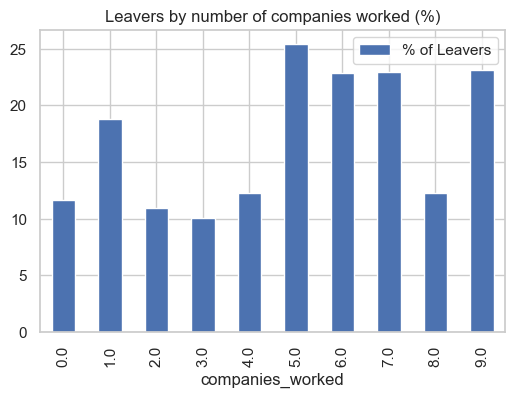

In [42]:
df_companies_worked = pd.DataFrame(columns = ['companies_worked', '% of Leavers'])
for i, companies in enumerate(list(df.NumCompaniesWorked.unique())):
    ratio = df[(df.NumCompaniesWorked == companies) & (df.Attrition == 'Yes')].shape[0] / df[df.NumCompaniesWorked == companies].shape[0]
    df_companies_worked.loc[i] = (companies, ratio * 100)
df_CW = df_companies_worked.groupby(by = 'companies_worked').sum()
df_CW.plot(kind = 'bar', title = 'Leavers by number of companies worked (%)')

### Years at the company

In [43]:
print('Average no. of years at the company for: Current employees = {:.2f}; Ex-employees = {:.2f}'.format((df[df.Attrition == 'No'].YearsAtCompany.mean()), 
                                                                                                          (df[df.Attrition == 'Yes'].YearsAtCompany.mean())))

Average no. of years at the company for: Current employees = 7.37; Ex-employees = 5.13


In [44]:
print(df.YearsAtCompany.min(), df.YearsAtCompany.max())

0 40


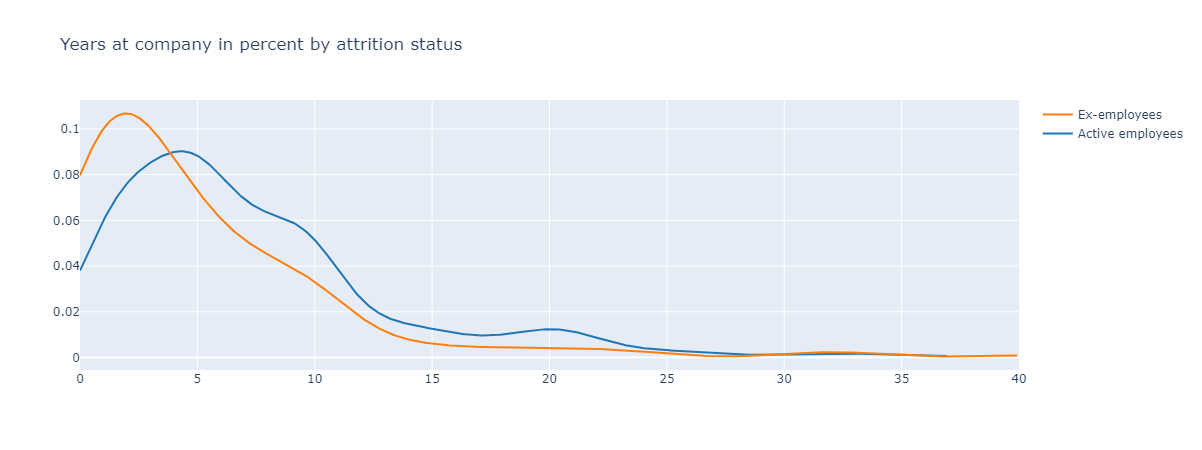

In [45]:
x1 = df.loc[df.Attrition == 'No', 'YearsAtCompany']
x2 = df.loc[df.Attrition == 'Yes', 'YearsAtCompany']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Years at company in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='YearsAtCompany'>

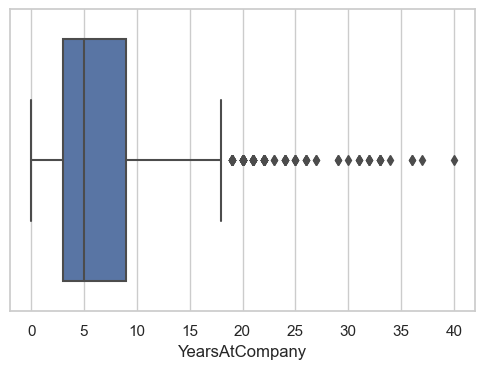

In [46]:
sns.boxplot(x = df.YearsAtCompany)

- Seems like the feature has outliers but there might be cases in which the employee works in the company for 40 years.

### No. of years in current role

In [47]:
df.YearsInCurrentRole.nunique()

19

In [48]:
print('Min : {}, Max : {}'.format(df.YearsInCurrentRole.min(), df.YearsInCurrentRole.max()))

Min : 0, Max : 18


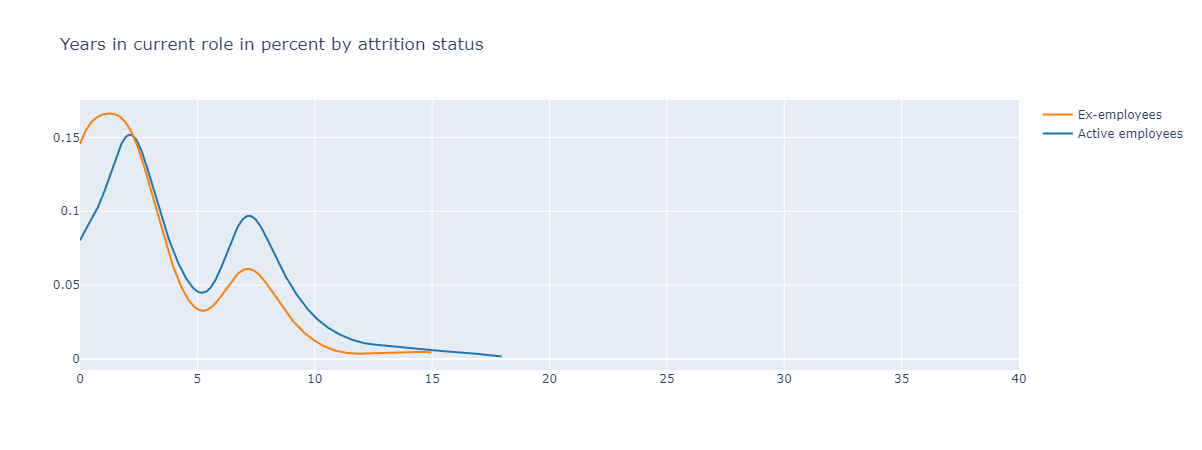

In [49]:
x1 = df.loc[df.Attrition == 'No', 'YearsInCurrentRole']
x2 = df.loc[df.Attrition == 'Yes', 'YearsInCurrentRole']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Years in current role in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='YearsInCurrentRole'>

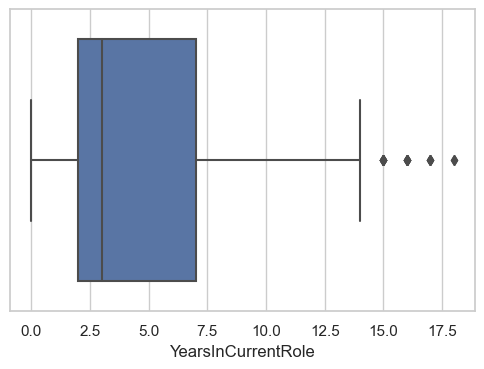

In [50]:
sns.boxplot(x = df.YearsInCurrentRole)

<AxesSubplot:xlabel='YearsInCurrentRole', ylabel='JobLevel'>

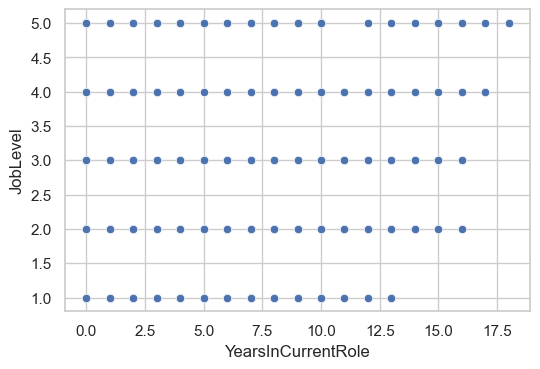

In [51]:
sns.scatterplot(x = df.YearsInCurrentRole, y = df.JobLevel)

- Since the people working for 15 years or greater in the same role are having a much higher job role than others, they cannot be considered as outliers.

### Total working years

In [52]:
df.TotalWorkingYears.nunique()

40

In [53]:
print('Min : {}, Max : {}'.format(df.TotalWorkingYears.min(), df.TotalWorkingYears.max()))

Min : 0, Max : 40


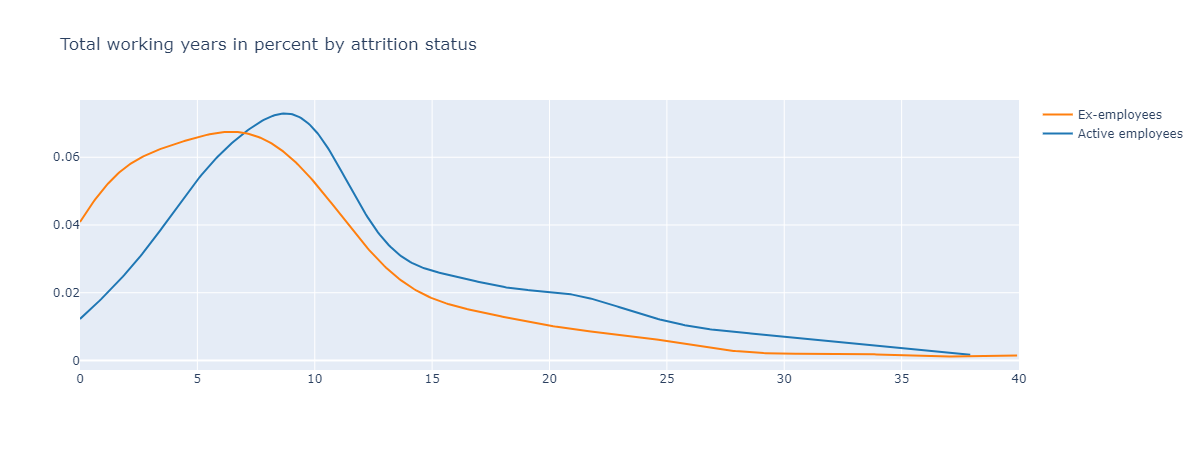

In [54]:
x1 = df.loc[df.Attrition == 'No', 'TotalWorkingYears']
x2 = df.loc[df.Attrition == 'Yes', 'TotalWorkingYears']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Total working years in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='TotalWorkingYears'>

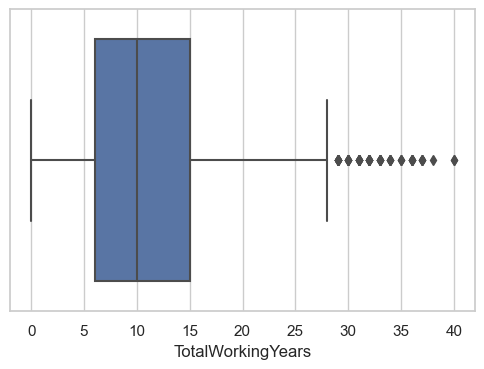

In [55]:
sns.boxplot(x = df.TotalWorkingYears)

### Years with current manager

In [56]:
df.YearsWithCurrManager.nunique()

18

In [57]:
print('Min : {}, Max : {}'.format(df.YearsWithCurrManager.min(), df.YearsWithCurrManager.max()))

Min : 0, Max : 17


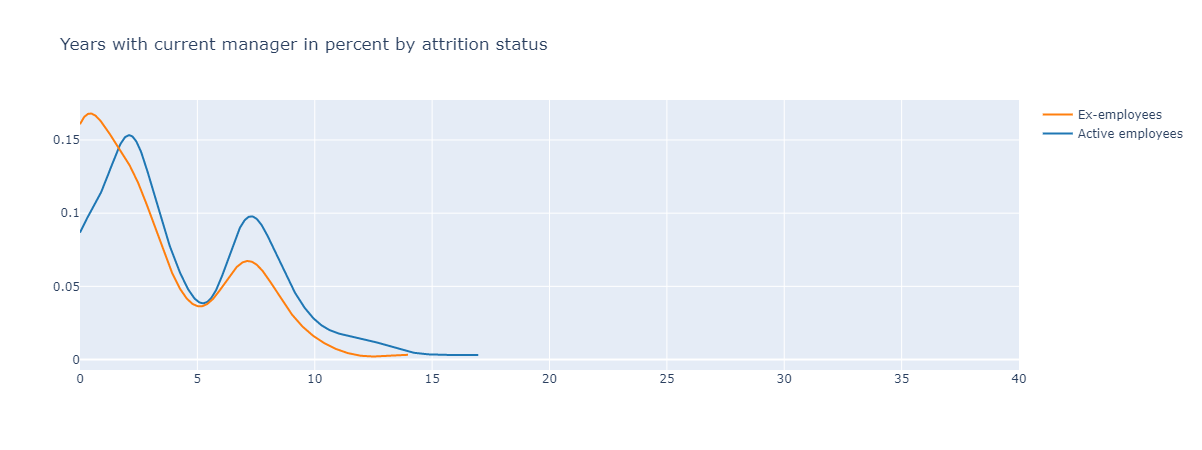

In [58]:
x1 = df.loc[df.Attrition == 'No', 'YearsWithCurrManager']
x2 = df.loc[df.Attrition == 'Yes', 'YearsWithCurrManager']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Years with current manager in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [0, 40], dtick = 5))
fig.show()

<AxesSubplot:xlabel='YearsWithCurrManager'>

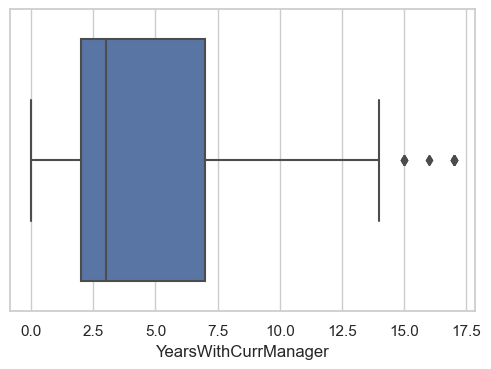

In [59]:
sns.boxplot(x = df.YearsWithCurrManager)

### Work-life balance score

In [60]:
df.WorkLifeBalance.value_counts()

3    893
2    344
4    153
1     80
Name: WorkLifeBalance, dtype: int64

<AxesSubplot:title={'center':'Leavers by worklife balance (%)'}, xlabel='worklife_balance'>

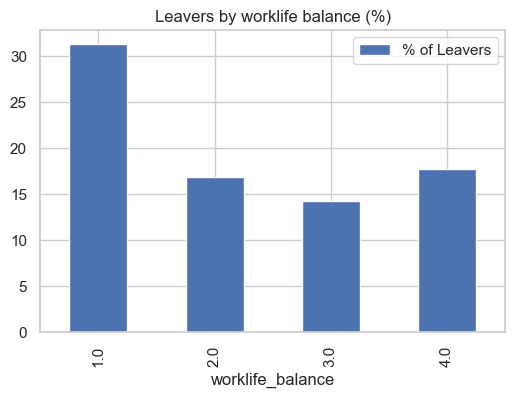

In [61]:
df_worklife_balance = pd.DataFrame(columns = ['worklife_balance', '% of Leavers'])
for i, worklife in enumerate(list(df.WorkLifeBalance.unique())):
    ratio = df[(df.WorkLifeBalance == worklife) & (df.Attrition == 'Yes')].shape[0] / df[df.WorkLifeBalance == worklife].shape[0]
    df_worklife_balance.loc[i] = (worklife, ratio * 100)
df_WLB = df_worklife_balance.groupby(by = 'worklife_balance').sum()
df_WLB.plot(kind = 'bar', title = 'Leavers by worklife balance (%)')

### Overtime

In [62]:
df.OverTime.value_counts()

No     1054
Yes     416
Name: OverTime, dtype: int64

<AxesSubplot:title={'center':'Leavers by overtime (%)'}, xlabel='overtime'>

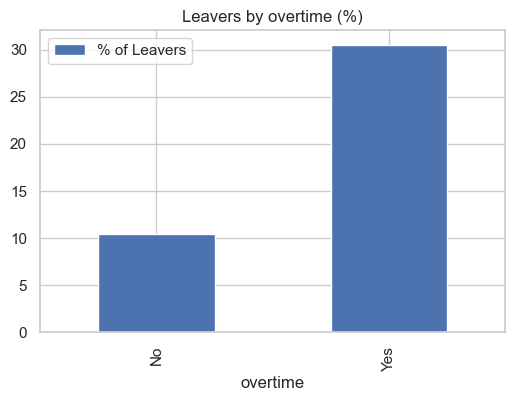

In [63]:
df_overtime = pd.DataFrame(columns = ['overtime', '% of Leavers'])
for i, overtime in enumerate(list(df.OverTime.unique())):
    ratio = df[(df.OverTime == overtime) & (df.Attrition == 'Yes')].shape[0] / df[df.OverTime == overtime].shape[0]
    df_overtime.loc[i] = (overtime, ratio * 100)
df_OT = df_overtime.groupby(by = 'overtime').sum()
df_OT.plot(kind = 'bar', title = 'Leavers by overtime (%)')

### Hourly rate

In [64]:
df.HourlyRate.nunique()

71

In [65]:
print('Min : {}, Max : {}'.format(df.HourlyRate.min(), df.HourlyRate.max()))

Min : 30, Max : 100


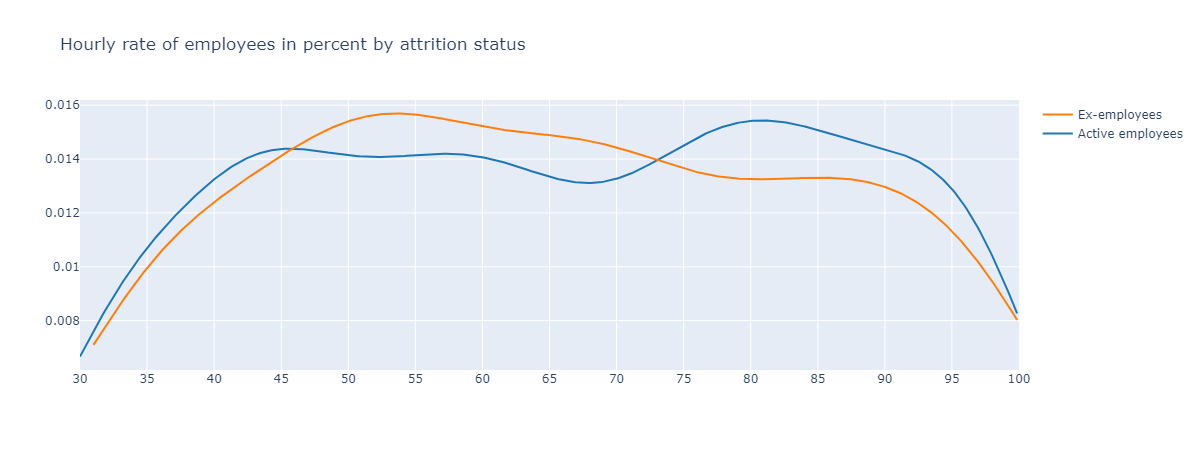

In [66]:
x1 = df.loc[df.Attrition == 'No', 'HourlyRate']
x2 = df.loc[df.Attrition == 'Yes', 'HourlyRate']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Hourly rate of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [30, 100], dtick = 5))
fig.show()

<AxesSubplot:xlabel='HourlyRate'>

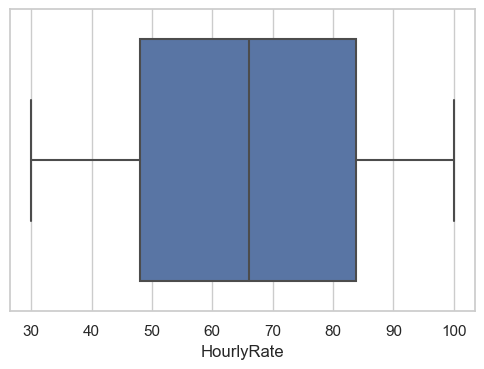

In [67]:
sns.boxplot(x = df.HourlyRate)

### Daily rate

In [68]:
df.DailyRate.nunique()

886

In [69]:
print('Min : {}, Max : {}'.format(df.DailyRate.min(), df.DailyRate.max()))

Min : 102, Max : 1499


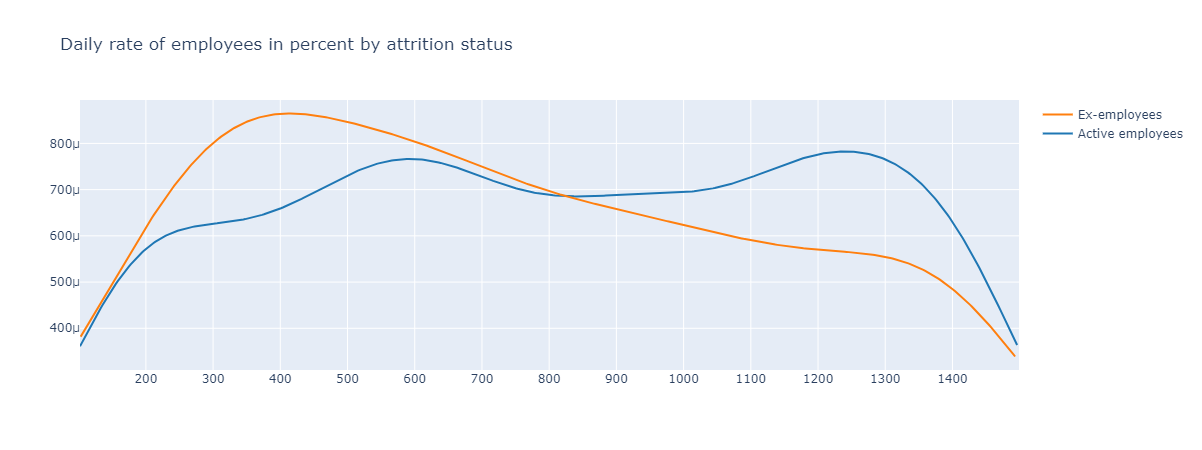

In [70]:
x1 = df.loc[df.Attrition == 'No', 'DailyRate']
x2 = df.loc[df.Attrition == 'Yes', 'DailyRate']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Daily rate of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [102, 1499], dtick = 100))
fig.show()

<AxesSubplot:xlabel='DailyRate'>

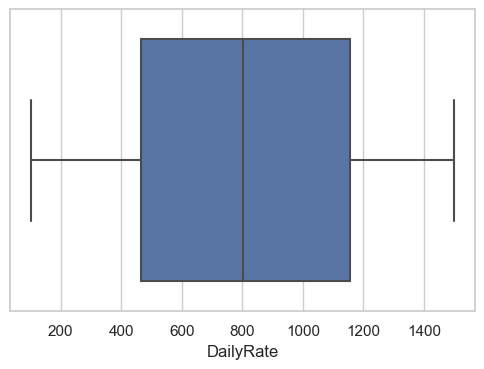

In [71]:
sns.boxplot(x = df.DailyRate)

### Monthly Rate

In [72]:
df.MonthlyRate.nunique()

1427

In [73]:
print('Min : {}, Max : {}'.format(df.MonthlyRate.min(), df.MonthlyRate.max()))

Min : 2094, Max : 26999


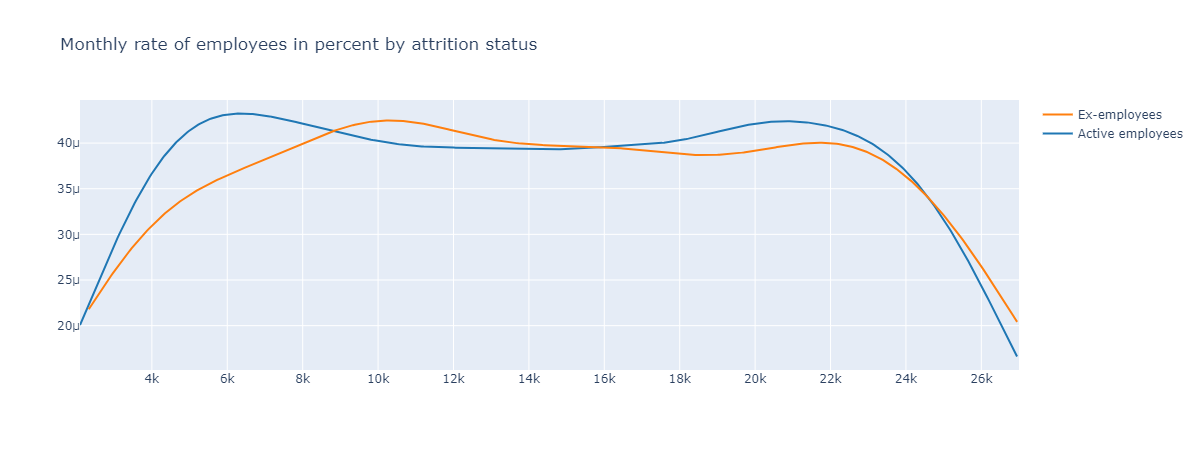

In [74]:
x1 = df.loc[df.Attrition == 'No', 'MonthlyRate']
x2 = df.loc[df.Attrition == 'Yes', 'MonthlyRate']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Monthly rate of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [2094, 26999], dtick = 2000))
fig.show()

<AxesSubplot:xlabel='MonthlyRate'>

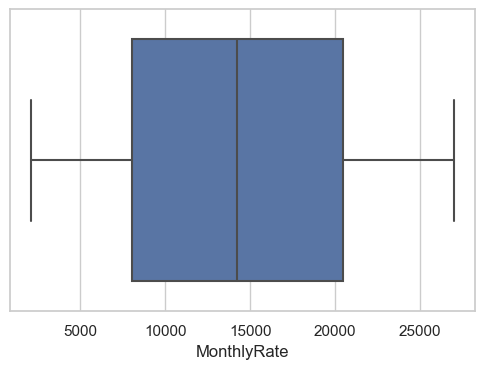

In [75]:
sns.boxplot(x = df.MonthlyRate)

### Monthly Income

In [76]:
df.MonthlyIncome.nunique()

1349

In [77]:
print('Min : {}, Max : {}'.format(df.MonthlyIncome.min(), df.MonthlyIncome.max()))

Min : 1009, Max : 19999


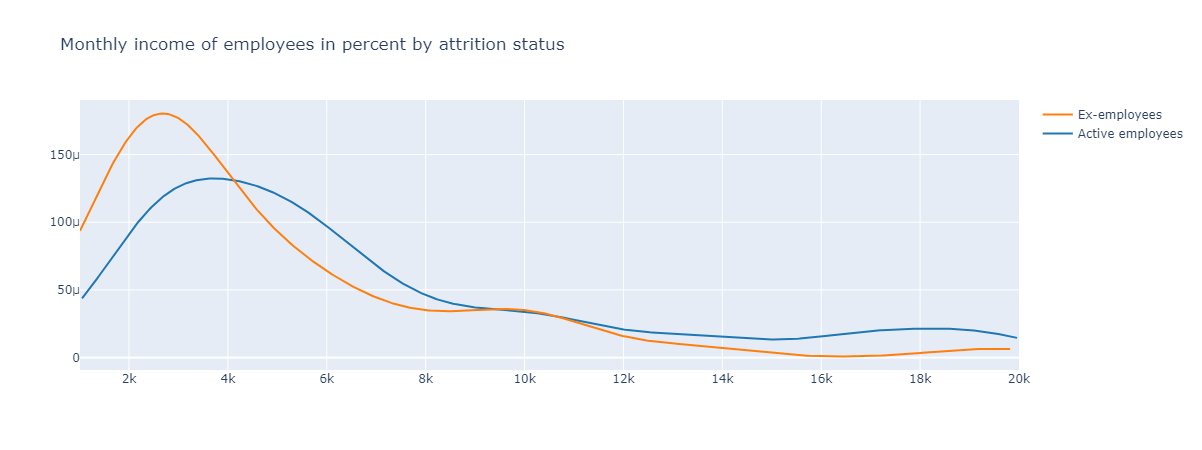

In [78]:
x1 = df.loc[df.Attrition == 'No', 'MonthlyIncome']
x2 = df.loc[df.Attrition == 'Yes', 'MonthlyIncome']
hist_data = [x1, x2]
group_labels = ['Active employees', 'Ex-employees']
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'kde', show_hist = False, show_rug = False)
fig['layout'].update(title = 'Monthly income of employees in percent by attrition status')
fig['layout'].update(xaxis = dict(range = [1009, 20000], dtick = 2000))
fig.show()

<AxesSubplot:xlabel='MonthlyIncome'>

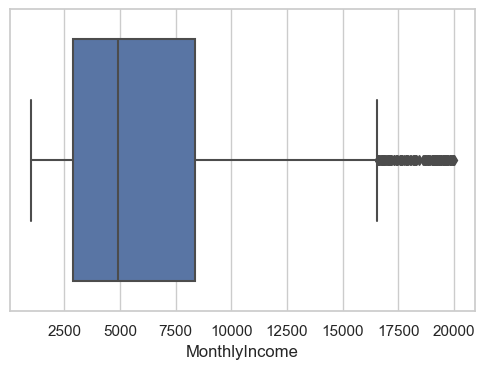

In [79]:
sns.boxplot(x = df.MonthlyIncome)

### Stock option

In [80]:
df.StockOptionLevel.nunique()

4

<AxesSubplot:title={'center':'Leavers by stock option level (%)'}, xlabel='stock_option_level'>

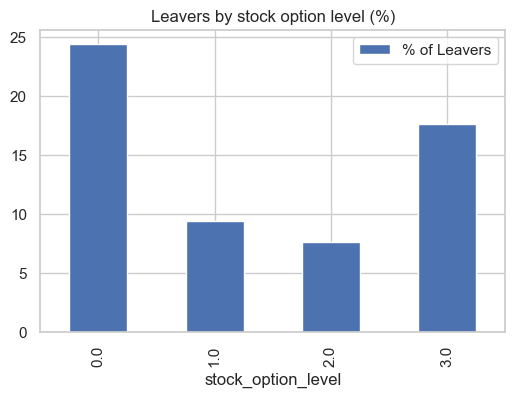

In [81]:
df_stock = pd.DataFrame(columns = ['stock_option_level', '% of Leavers'])
for i, stock in enumerate(list(df.StockOptionLevel.unique())):
    ratio = df[(df.StockOptionLevel == stock) & (df.Attrition == 'Yes')].shape[0] / df[df.StockOptionLevel == stock].shape[0]
    df_stock.loc[i] = (stock, ratio * 100)
df_SPL = df_stock.groupby(by = 'stock_option_level').sum()
df_SPL.plot(kind = 'bar', title = 'Leavers by stock option level (%)')

### Environment Satisfaction

In [82]:
df.EnvironmentSatisfaction.value_counts()

3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64

<AxesSubplot:title={'center':'Leavers by environment satisfaction (%)'}, xlabel='environment_satisfaction'>

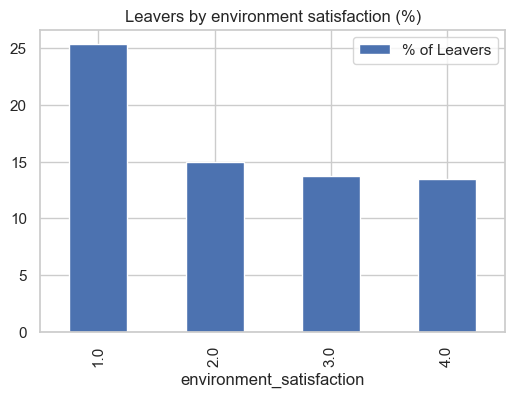

In [83]:
df_environment = pd.DataFrame(columns = ['environment_satisfaction', '% of Leavers'])
for i, environment in enumerate(list(df.EnvironmentSatisfaction.unique())):
    ratio = df[(df.EnvironmentSatisfaction == environment) & (df.Attrition == 'Yes')].shape[0] / df[df.EnvironmentSatisfaction == environment].shape[0]
    df_environment.loc[i] = (environment, ratio * 100)
df_ENV = df_environment.groupby(by = 'environment_satisfaction').sum()
df_ENV.plot(kind = 'bar', title = 'Leavers by environment satisfaction (%)')

### Job satisfaction

In [84]:
df.JobSatisfaction.value_counts()

4    459
3    442
1    289
2    280
Name: JobSatisfaction, dtype: int64

<AxesSubplot:title={'center':'Leavers by job satisfaction (%)'}, xlabel='job_satisfaction'>

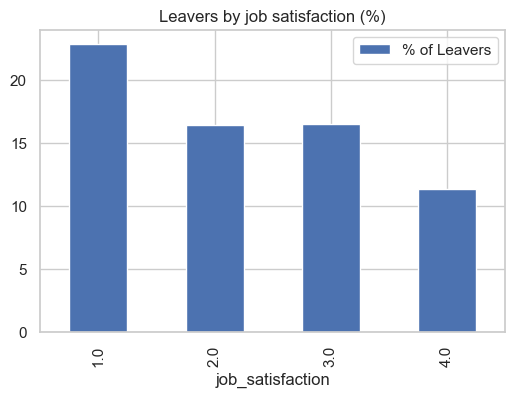

In [85]:
df_job_satisfaction = pd.DataFrame(columns = ['job_satisfaction', '% of Leavers'])
for i, satisfaction in enumerate(list(df.JobSatisfaction.unique())):
    ratio = df[(df.JobSatisfaction == satisfaction) & (df.Attrition == 'Yes')].shape[0] / df[df.JobSatisfaction == satisfaction].shape[0]
    df_job_satisfaction.loc[i] = (satisfaction, ratio * 100)
df_JS = df_job_satisfaction.groupby(by = 'job_satisfaction').sum()
df_JS.plot(kind = 'bar', title = 'Leavers by job satisfaction (%)')

### Relationship satisfaction

In [86]:
df.RelationshipSatisfaction.nunique()

4

<AxesSubplot:title={'center':'Leavers by relationship satisfaction (%)'}, xlabel='relationship_satisfaction'>

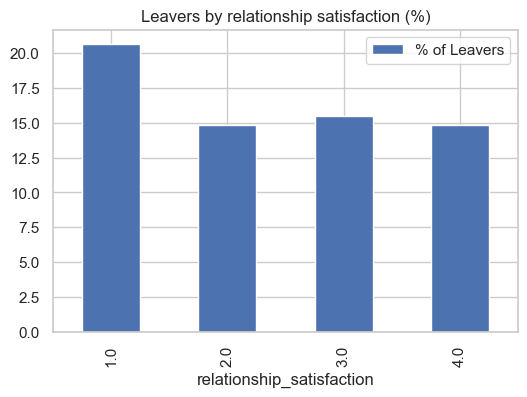

In [87]:
df_relationship = pd.DataFrame(columns = ['relationship_satisfaction', '% of Leavers'])
for i, relationship in enumerate(list(df.RelationshipSatisfaction.unique())):
    ratio = df[(df.RelationshipSatisfaction == relationship) & (df.Attrition == 'Yes')].shape[0] / df[df.RelationshipSatisfaction == relationship].shape[0]
    df_relationship.loc[i] = (relationship, ratio * 100)
df_RS = df_relationship.groupby(by = 'relationship_satisfaction').sum()
df_RS.plot(kind = 'bar', title = 'Leavers by relationship satisfaction (%)')

### Performance Rating

In [88]:
df.PerformanceRating.value_counts()

3    1244
4     226
Name: PerformanceRating, dtype: int64

<AxesSubplot:title={'center':'Leavers by performance rating (%)'}, xlabel='performance_rating'>

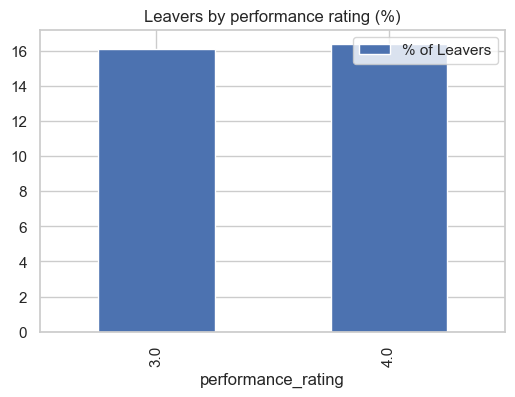

In [89]:
df_performance = pd.DataFrame(columns = ['performance_rating', '% of Leavers'])
for i, performance in enumerate(list(df.PerformanceRating.unique())):
    ratio = df[(df.PerformanceRating == performance) & (df.Attrition == 'Yes')].shape[0] / df[df.PerformanceRating == performance].shape[0]
    df_performance.loc[i] = (performance, ratio * 100)
df_PR = df_performance.groupby(by = 'performance_rating').sum()
df_PR.plot(kind = 'bar', title = 'Leavers by performance rating (%)')

### Attrition - target variable

In [90]:
df.Attrition.value_counts(normalize = 'True')

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

<AxesSubplot:xlabel='Attrition', ylabel='count'>

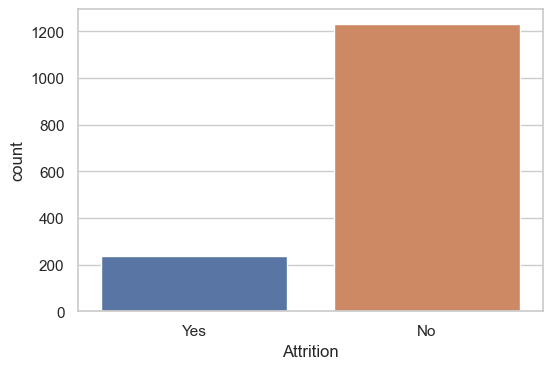

In [91]:
sns.countplot(x = df.Attrition)

### Correlation

In [92]:
df_copy = df.copy()

In [93]:
df_copy['target'] = df_copy.Attrition.apply(lambda x : 0 if x == 'No' else 1)
df_copy = df_copy.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis = 1)
df_copy.head()

Age     BusinessTravel  DailyRate              Department  \
0   41      Travel_Rarely       1102                   Sales   
1   49  Travel_Frequently        279  Research & Development   
2   37      Travel_Rarely       1373  Research & Development   
3   33  Travel_Frequently       1392  Research & Development   
4   27      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction  \
0                 1          2  Life Sciences                        2   
1                 8          1  Life Sciences                        3   
2                 2          2          Other                        4   
3                 3          4  Life Sciences                        4   
4                 2          1        Medical                        1   

   Gender  HourlyRate  ...  RelationshipSatisfaction  StockOptionLevel  \
0  Female          94  ...                         1                 0   
1    Male          61  ...                         4                 1   
2    Male          92  ...                         2                 0   
3  Female          56  ...                         3                 0   
4    Male          40  ...                         4                 1   

  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                 8                      0               1               6   
1                10                      3               3              10   
2                 7                      3               3               0   
3                 8                      3               3               8   
4                 6                      3               3               2   

   YearsInCurrentRole  YearsSinceLastPromotion YearsWithCurrManager  target  
0                   4                        0                    5       1  
1                   7                        1                    7       0  
2                   0                        0                    0       1  
3                   7                        3                    0       0  
4                   2                        2                    2       0  

[5 rows x 31 columns]

In [94]:
correlations = df_copy.corr()['target'].sort_values()
correlations

TotalWorkingYears          -0.171063
JobLevel                   -0.169105
YearsInCurrentRole         -0.160545
MonthlyIncome              -0.159840
Age                        -0.159205
YearsWithCurrManager       -0.156199
StockOptionLevel           -0.137145
YearsAtCompany             -0.134392
JobInvolvement             -0.130016
JobSatisfaction            -0.103481
EnvironmentSatisfaction    -0.103369
WorkLifeBalance            -0.063939
TrainingTimesLastYear      -0.059478
DailyRate                  -0.056652
RelationshipSatisfaction   -0.045872
YearsSinceLastPromotion    -0.033019
Education                  -0.031373
PercentSalaryHike          -0.013478
HourlyRate                 -0.006846
PerformanceRating           0.002889
MonthlyRate                 0.015170
NumCompaniesWorked          0.043494
DistanceFromHome            0.077924
target                      1.000000
Name: target, dtype: float64

In [95]:
corr = df_copy.corr()
mask = np.zeros_like(corr)

In [96]:
mask.shape

(24, 24)

In [97]:
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

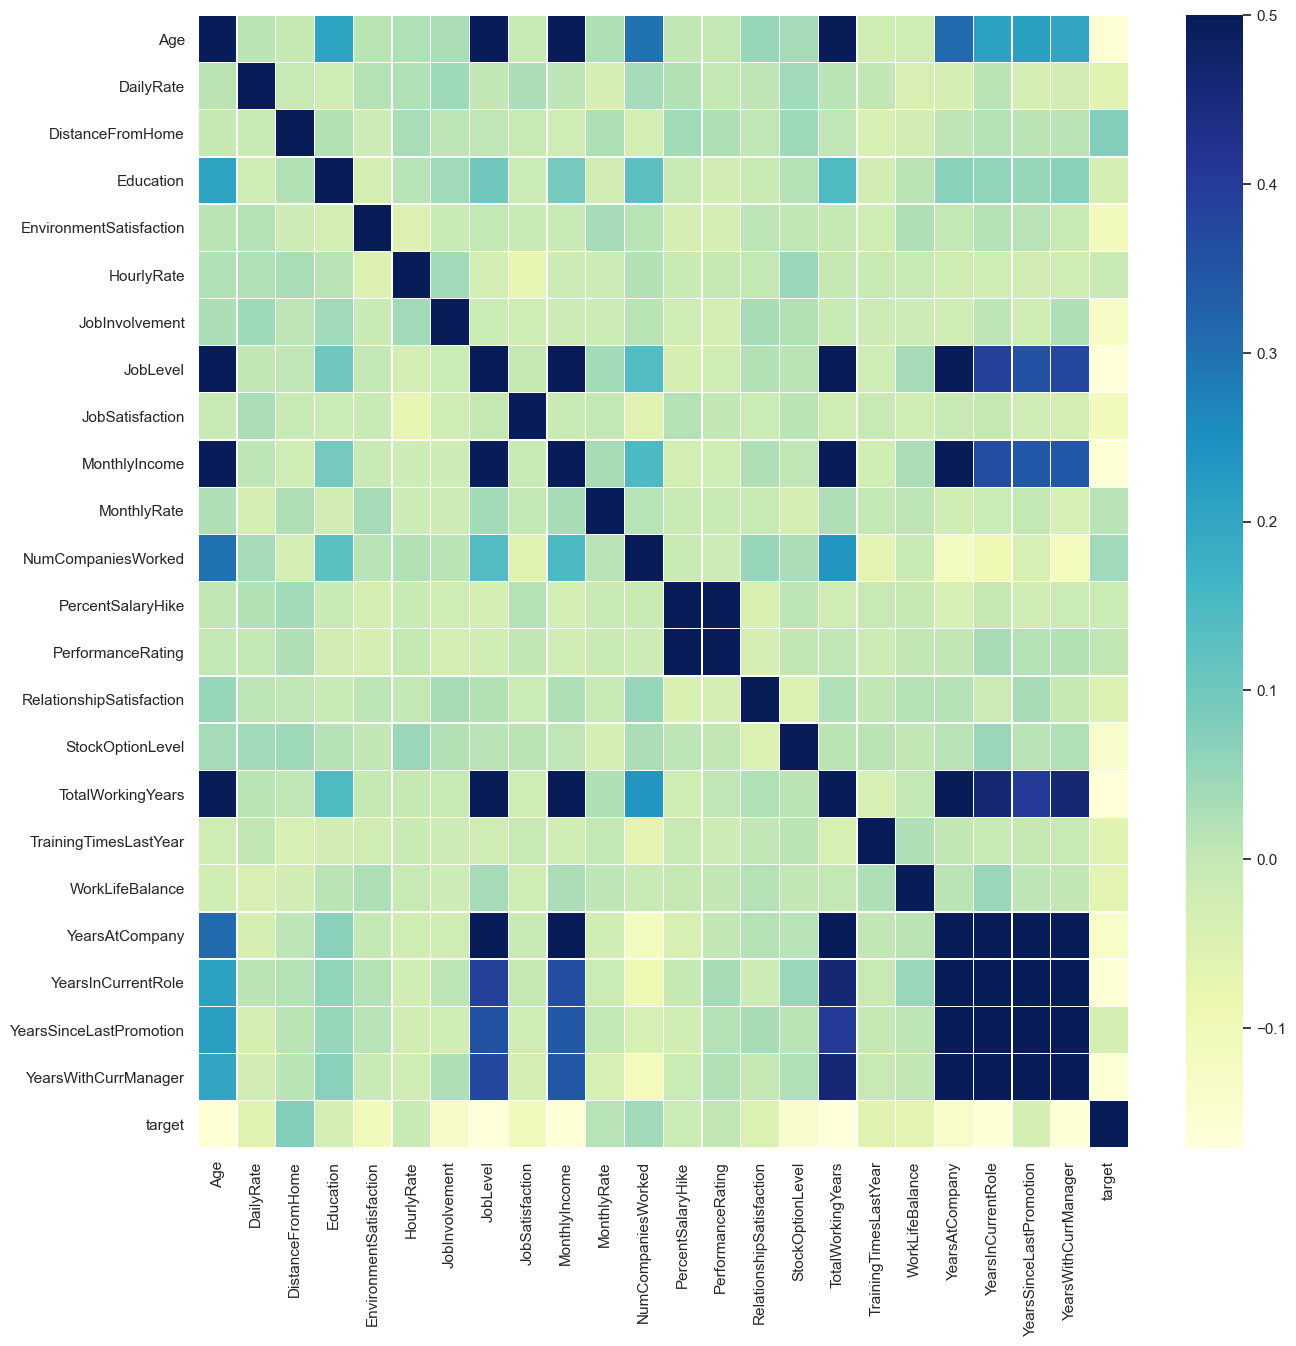

In [98]:
plt.figure(figsize = (15, 15))
sns.heatmap(corr, vmax = .5, linewidth = 0.2, cmap = 'YlGnBu')

## Preprocessing

### Encoding

- Label encoding for features having less than or equal to 2 unique values and one-hot encoding for others.

In [99]:
le = LabelEncoder()

In [100]:
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [101]:
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded'.format(le_count))

4 columns were label encoded


In [102]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [103]:
df = pd.get_dummies(df, drop_first = True)

In [104]:
df.columns

Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRo

### Data splitting

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int32
 2   DailyRate                          1470 non-null   int64
 3   DistanceFromHome                   1470 non-null   int64
 4   Education                          1470 non-null   int64
 5   EmployeeCount                      1470 non-null   int64
 6   EmployeeNumber                     1470 non-null   int64
 7   EnvironmentSatisfaction            1470 non-null   int64
 8   Gender                             1470 non-null   int32
 9   HourlyRate                         1470 non-null   int64
 10  JobInvolvement                     1470 non-null   int64
 11  JobLevel                           1470 non-null   int64
 12  JobSatisfaction     

In [106]:
target = np.array(df.Attrition)

In [107]:
df = df.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis = 1)

In [108]:
df.shape

(1470, 44)

In [109]:
features = np.array(df)

## Splitting the data

In [110]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 42, stratify = target)

In [111]:
x_train.shape

(1102, 44)

In [112]:
x_test.shape

(368, 44)

In [113]:
y_train.shape

(1102,)

In [114]:
y_test.shape

(368,)

In [115]:
len(y_train[y_train == 1])/len(y_train)

0.16152450090744103

In [116]:
len(y_test[y_test == 1])/len(y_test)

0.16032608695652173

## Building the ML model

In [117]:
models = []

In [118]:
models.append(('logistic_regression', LogisticRegression(solver = 'liblinear', random_state = 42)))
models.append(('random_forest', RandomForestClassifier(random_state = 42)))
models.append(('svm', SVC(random_state = 42)))
models.append(('knn', KNeighborsClassifier()))
models.append(('decision_tree_classifier', DecisionTreeClassifier(random_state = 42)))
models.append(('gaussian_nb', GaussianNB()))
models.append(('xgboost', XGBClassifier(use_label_encoder = False, random_state = 42, eval_metric = 'error')))
models.append(('lightgbm', LGBMClassifier(random_state = 42)))
models.append(('catboost', CatBoostClassifier(random_state = 42)))

In [119]:
models

[('logistic_regression',
  LogisticRegression(random_state=42, solver='liblinear')),
 ('random_forest', RandomForestClassifier(random_state=42)),
 ('svm', SVC(random_state=42)),
 ('knn', KNeighborsClassifier()),
 ('decision_tree_classifier', DecisionTreeClassifier(random_state=42)),
 ('gaussian_nb', GaussianNB()),
 ('xgboost',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, eval_metric='error',
                gamma=None, gpu_id=None, importance_type='gain',
                interaction_constraints=None, learning_rate=None,
                max_delta_step=None, max_depth=None, min_child_weight=None,
                missing=nan, monotone_constraints=None, n_estimators=100,
                n_jobs=None, num_parallel_tree=None, random_state=42,
                reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
                subsample=None, tree_method=None, use_label_encoder=False,
                val

In [120]:
acc_results = []
auc_results = []
names = []
col = ['Algorithm', 'ROC AUC mean', 'ROC AUC std', 'Accuracy mean', 'Accuracy std']

In [121]:
df_results = pd.DataFrame(columns = col)

In [122]:
i = 0
for name, model in models:
    kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    cv_acc_results = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy')
    cv_auc_results = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name, round(cv_auc_results.mean() * 100, 2), round(cv_auc_results.std() * 100, 2), round(cv_acc_results.mean() * 100, 2), 
                         round(cv_acc_results.std() * 100, 2)]
    i += 1

Learning rate set to 0.010263
0:	learn: 0.6868197	total: 159ms	remaining: 2m 39s
1:	learn: 0.6791050	total: 161ms	remaining: 1m 20s
2:	learn: 0.6715849	total: 163ms	remaining: 54.3s
3:	learn: 0.6649527	total: 165ms	remaining: 41.2s
4:	learn: 0.6583690	total: 167ms	remaining: 33.3s
5:	learn: 0.6525625	total: 168ms	remaining: 27.9s
6:	learn: 0.6462505	total: 170ms	remaining: 24.2s
7:	learn: 0.6388675	total: 173ms	remaining: 21.5s
8:	learn: 0.6303526	total: 176ms	remaining: 19.4s
9:	learn: 0.6235707	total: 178ms	remaining: 17.7s
10:	learn: 0.6174442	total: 181ms	remaining: 16.3s
11:	learn: 0.6114739	total: 184ms	remaining: 15.1s
12:	learn: 0.6060760	total: 186ms	remaining: 14.1s
13:	learn: 0.6002266	total: 188ms	remaining: 13.3s
14:	learn: 0.5953994	total: 190ms	remaining: 12.5s
15:	learn: 0.5900841	total: 193ms	remaining: 11.8s
16:	learn: 0.5853355	total: 195ms	remaining: 11.3s
17:	learn: 0.5798878	total: 197ms	remaining: 10.8s
18:	learn: 0.5743706	total: 200ms	remaining: 10.3s
19:	learn

In [123]:
df_results

Algorithm  ROC AUC mean  ROC AUC std  Accuracy mean  \
0       logistic_regression         81.78         6.84          86.75   
1             random_forest         80.94         5.51          86.12   
2                       svm         51.03         6.18          83.85   
3                       knn         59.23         5.91          81.85   
4  decision_tree_classifier         58.04         4.09          77.49   
5               gaussian_nb         76.72         6.95          76.67   
6                   xgboost         81.50         5.67          86.66   
7                  lightgbm         81.78         6.23          86.21   
8                  catboost         82.57         5.74          87.20   

   Accuracy std  
0          2.39  
1          1.65  
2          0.35  
3          2.18  
4          2.82  
5          5.49  
6          1.79  
7          1.54  
8          1.44

In [124]:
df_results.sort_values(by = ['ROC AUC mean'], ascending = False)

Algorithm  ROC AUC mean  ROC AUC std  Accuracy mean  \
8                  catboost         82.57         5.74          87.20   
0       logistic_regression         81.78         6.84          86.75   
7                  lightgbm         81.78         6.23          86.21   
6                   xgboost         81.50         5.67          86.66   
1             random_forest         80.94         5.51          86.12   
5               gaussian_nb         76.72         6.95          76.67   
3                       knn         59.23         5.91          81.85   
4  decision_tree_classifier         58.04         4.09          77.49   
2                       svm         51.03         6.18          83.85   

   Accuracy std  
8          1.44  
0          2.39  
7          1.54  
6          1.79  
1          1.65  
5          5.49  
3          2.18  
4          2.82  
2          0.35

- catboost gives the best auc score

## Hyperparameter tuning

In [125]:
params = {'depth' : [4,5,6,7,8,9,10],
          'learning_rate' : [0.001, 0.01, 0.1, 0.5],
          'iterations' : [100, 200, 500, 700, 1000, 2000]}

In [126]:
model = CatBoostClassifier(random_state = 42)

In [127]:
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
grid_search = GridSearchCV(estimator = model, param_grid = params, cv = kfold, n_jobs = -1, scoring = 'roc_auc', verbose = 0)

In [ ]:
grid_search.fit(x_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_